Frame enumuration and submission to Hyp3 with Tropo, Iono, SET corrections.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from s1_frame_enumerator import (get_s1_stack, 
                                 filter_s1_stack_by_geometric_coverage_per_pass, 
                                 get_global_s1_frames, 
                                 get_overlapping_s1_frames, 
                                 enumerate_dates, 
                                 frames2gdf, 
                                 enumerate_gunw_time_series)
from shapely.geometry import Point
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import warnings
import json
import pandas as pd
import datetime
from tqdm import tqdm

# CA

<Axes: >

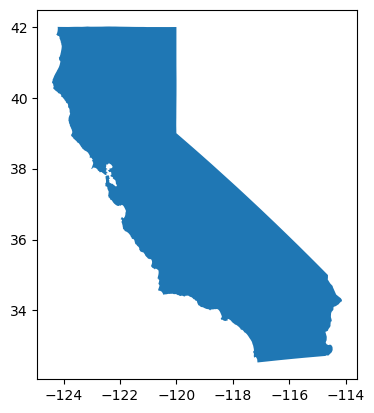

In [3]:
df_ca = gpd.read_file('https://raw.githubusercontent.com/ropensci/geojsonio/main/inst/examples/california.geojson')
# This ensures we only get the mainland part
df_ca.geometry = [df_ca.geometry[0].geoms[-1]]
df_ca.plot()

# Parameters

In [4]:
TEMPORAL_BASELINES_DAYS = [0, 30, 365]
WEATHER_MODEL = 'HRRR'
NEIGHBORS = 3

An erosion ensures not too many frames off the coast. Play with the buffer as an easy way to exclude frames with lots of water and likely poor spatial coverage (i.e. SLC availability).

In [5]:
frames = get_overlapping_s1_frames(df_ca.geometry.unary_union.buffer(-.25))
df_frames_all = frames2gdf(frames)
df_frames_all.head()

,frame_id,hemisphere,track_number_min,track_number_max,geometry
0,1930,None,13,13,"POLYGON Z ((-126.01264 40.75129 0.00000, -125...."
1,1931,None,13,13,"POLYGON Z ((-126.25208 39.59170 0.00000, -126...."
2,1932,None,13,13,"POLYGON Z ((-126.48927 38.43175 0.00000, -126...."
3,5286,None,35,35,"POLYGON Z ((-123.00511 34.17223 0.00000, -123...."
4,5287,None,35,35,"POLYGON Z ((-123.28214 35.34912 0.00000, -123...."


In [6]:
all_tracks = df_frames_all.track_number_min.unique().tolist() + df_frames_all.track_number_max.unique().tolist()
all_tracks = sorted(list(set(all_tracks)))
all_tracks

[13, 35, 42, 64, 71, 93, 100, 108, 115, 137, 144, 166, 173]

(30.78421186522863, 43.88251499612947)

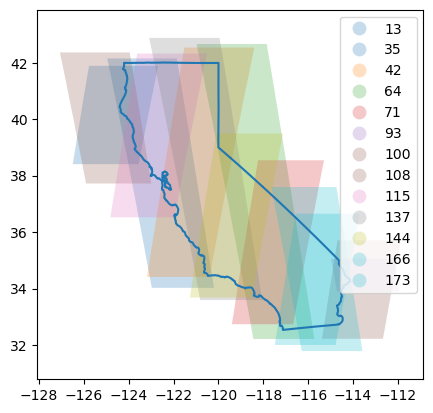

In [7]:
fig, ax = plt.subplots()
df_ca.boundary.plot(ax=ax)
df_frames_by_track = df_frames_all.dissolve(by='track_number_min').reset_index(drop=False)
df_frames_by_track.plot(ax=ax, 
                        column='track_number_min',
                        categorical=True,
                        alpha=.25, 
                        legend=True)
xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

# Get Stack from Frame

These parameters are for testing. Can set `SUBSET_OF_TRACKS` to `False` to use all tracks. 

In [8]:
SUBSET_OF_TRACKS = True
N_TRACKS_FOR_SUBSET = 2

In [9]:
frames_for_each_track = [[f for f in frames if track in f.track_numbers] for track in all_tracks]

In [10]:
if SUBSET_OF_TRACKS:
    frames_for_each_track_subset = frames_for_each_track[:N_TRACKS_FOR_SUBSET]
else:
    frames_for_each_track_subset = frames_for_each_track[:]

In [11]:
list_of_stacks = list(map(get_s1_stack, tqdm(frames_for_each_track_subset)))

 50%|█████████████████▌                 | 1/2 [00:46<00:46, 46.80s/it]
/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:80: UserWarning: Frame 5286 did not have enough coverage on 2016-10-03 (ratio of coverage was 0.21)
  warn(f'Frame {frame.frame_id} did not have enough coverage '
/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:80: UserWarning: Frame 5286 did not have enough coverage on 2016-10-27 (ratio of coverage was 0.21)
  warn(f'Frame {frame.frame_id} did not have enough coverage '
/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:80: UserWarning: Frame 5286 did not have enough coverage on 2016-11-20 (ratio of coverage was 0.21)
  warn(f'Frame {frame.frame_id} did not have enough coverage '
/Users/cmarshak/bekaert-team/s1-frame-enumerator/s1_frame_enumerator/s1_stack.py:80: UserWarning: Frame 5286 did not have enough coverage on 2016-12-14 (ratio of coverage was 0.21)
  warn(f'Frame {

There are numerous options to increase temporal coverage if certain dates (as noted in the warnings above) are excluded from the time series. Specifically:

1. Lower the coverage ratios (per pass and per frame)
2. Exclude the noted frames (in the warnings) from consideration

Again, this is the common balancing of spatial coverage and temporal coverage (increasing one decreases the other and vice versa).

# Generate Pairs

In [12]:
all_submissions = []
for tb in tqdm(TEMPORAL_BASELINES_DAYS, desc='temporal baselines'):
    for frames, df_stack in zip(tqdm(frames_for_each_track_subset, desc=('Enumerating stacks with min. '
                                                                         f'temporal baseline {tb} days ')), 
                                       list_of_stacks):

        data = enumerate_gunw_time_series(df_stack, 
                                          tb, 
                                          n_secondary_scenes_per_ref=NEIGHBORS,
                                          frames=frames 
                                         )
        submission_data = {'ifg_inputs': data,
                           'tracks': frames[0].track_numbers,
                           'min_temporal_baseline': tb}
        all_submissions.append(submission_data)

temporal baselines:   0%|                       | 0/3 [00:00<?, ?it/s]
Enumerating stacks with min. temporal baseline 0 days :   0%| | 0/2 [0

Date Pairs:   0%|                             | 0/621 [00:00<?, ?it/s]

Date Pairs:   0%|                     | 2/621 [00:00<00:50, 12.31it/s]

Date Pairs:   1%|▏                    | 4/621 [00:00<00:50, 12.19it/s]

Date Pairs:   1%|▏                    | 6/621 [00:00<00:49, 12.54it/s]

Date Pairs:   1%|▎                    | 8/621 [00:00<00:48, 12.72it/s]

Date Pairs:   2%|▎                   | 10/621 [00:00<00:47, 12.79it/s]

Date Pairs:   2%|▍                   | 12/621 [00:00<00:47, 12.82it/s]

Date Pairs:   2%|▍                   | 14/621 [00:01<00:47, 12.78it/s]

Date Pairs:   3%|▌                   | 16/621 [00:01<00:47, 12.81it/s]

Date Pairs:   3%|▌                   | 18/621 [00:01<00:46, 12.94it/s]

Date Pairs:   3%|▋                   | 20/621 [00:01<00:46, 12.99it/s]

Date Pairs:   4%|▋                   | 22/621 [00:01<00:46, 12.99

Date Pairs:  33%|██████▎            | 206/621 [00:15<00:32, 12.94it/s]

Date Pairs:  33%|██████▎            | 208/621 [00:16<00:31, 12.97it/s]

Date Pairs:  34%|██████▍            | 210/621 [00:16<00:31, 12.97it/s]

Date Pairs:  34%|██████▍            | 212/621 [00:16<00:31, 13.01it/s]

Date Pairs:  34%|██████▌            | 214/621 [00:16<00:31, 12.97it/s]

Date Pairs:  35%|██████▌            | 216/621 [00:16<00:31, 12.90it/s]

Date Pairs:  35%|██████▋            | 218/621 [00:16<00:31, 12.92it/s]

Date Pairs:  35%|██████▋            | 220/621 [00:17<00:30, 12.96it/s]

Date Pairs:  36%|██████▊            | 222/621 [00:17<00:30, 13.00it/s]

Date Pairs:  36%|██████▊            | 224/621 [00:17<00:30, 12.87it/s]

Date Pairs:  36%|██████▉            | 226/621 [00:17<00:30, 13.00it/s]

Date Pairs:  37%|██████▉            | 228/621 [00:17<00:30, 12.98it/s]

Date Pairs:  37%|███████            | 230/621 [00:17<00:30, 12.99it/s]

Date Pairs:  37%|███████            | 232/621 [00:18<00:30, 12.7

Date Pairs:  67%|████████████▋      | 416/621 [00:32<00:15, 13.00it/s]

Date Pairs:  67%|████████████▊      | 418/621 [00:32<00:15, 12.97it/s]

Date Pairs:  68%|████████████▊      | 420/621 [00:32<00:15, 13.04it/s]

Date Pairs:  68%|████████████▉      | 422/621 [00:32<00:15, 13.04it/s]

Date Pairs:  68%|████████████▉      | 424/621 [00:32<00:15, 13.06it/s]

Date Pairs:  69%|█████████████      | 426/621 [00:32<00:14, 13.12it/s]

Date Pairs:  69%|█████████████      | 428/621 [00:33<00:14, 13.09it/s]

Date Pairs:  69%|█████████████▏     | 430/621 [00:33<00:14, 12.91it/s]

Date Pairs:  70%|█████████████▏     | 432/621 [00:33<00:14, 12.90it/s]

Date Pairs:  70%|█████████████▎     | 434/621 [00:33<00:14, 12.93it/s]

Date Pairs:  70%|█████████████▎     | 436/621 [00:33<00:14, 12.95it/s]

Date Pairs:  71%|█████████████▍     | 438/621 [00:33<00:14, 12.97it/s]

Date Pairs:  71%|█████████████▍     | 440/621 [00:34<00:14, 12.52it/s]

Date Pairs:  71%|█████████████▌     | 442/621 [00:34<00:14, 12.4

Date Pairs:   0%|                     | 1/747 [00:00<02:30,  4.97it/s]

Date Pairs:   0%|                     | 2/747 [00:00<02:30,  4.95it/s]

Date Pairs:   0%|                     | 3/747 [00:00<02:29,  4.97it/s]

Date Pairs:   1%|                     | 4/747 [00:00<02:28,  4.99it/s]

Date Pairs:   1%|▏                    | 5/747 [00:01<02:28,  4.98it/s]

Date Pairs:   1%|▏                    | 6/747 [00:01<02:29,  4.95it/s]

Date Pairs:   1%|▏                    | 7/747 [00:01<02:28,  4.98it/s]

Date Pairs:   1%|▏                    | 8/747 [00:01<02:28,  4.97it/s]

Date Pairs:   1%|▎                    | 9/747 [00:01<02:28,  4.96it/s]

Date Pairs:   1%|▎                   | 10/747 [00:02<02:28,  4.95it/s]

Date Pairs:   1%|▎                   | 11/747 [00:02<02:29,  4.92it/s]

Date Pairs:   2%|▎                   | 12/747 [00:02<02:28,  4.94it/s]

Date Pairs:   2%|▎                   | 13/747 [00:02<02:27,  4.97it/s]

Date Pairs:   2%|▎                   | 14/747 [00:02<02:27,  4.9

Date Pairs:  14%|██▋                | 106/747 [00:21<02:11,  4.88it/s]

Date Pairs:  14%|██▋                | 107/747 [00:21<02:09,  4.93it/s]

Date Pairs:  14%|██▋                | 108/747 [00:22<02:09,  4.94it/s]

Date Pairs:  15%|██▊                | 109/747 [00:22<02:08,  4.97it/s]

Date Pairs:  15%|██▊                | 110/747 [00:22<02:08,  4.95it/s]

Date Pairs:  15%|██▊                | 111/747 [00:22<02:08,  4.96it/s]

Date Pairs:  15%|██▊                | 112/747 [00:22<02:08,  4.95it/s]

Date Pairs:  15%|██▊                | 113/747 [00:23<02:09,  4.89it/s]

Date Pairs:  15%|██▉                | 114/747 [00:23<02:08,  4.92it/s]

Date Pairs:  15%|██▉                | 115/747 [00:23<02:07,  4.95it/s]

Date Pairs:  16%|██▉                | 116/747 [00:23<02:06,  4.98it/s]

Date Pairs:  16%|██▉                | 117/747 [00:23<02:05,  5.00it/s]

Date Pairs:  16%|███                | 118/747 [00:24<02:06,  4.98it/s]

Date Pairs:  16%|███                | 119/747 [00:24<02:05,  4.9

Date Pairs:  28%|█████▎             | 211/747 [00:43<01:48,  4.93it/s]

Date Pairs:  28%|█████▍             | 212/747 [00:43<01:48,  4.94it/s]

Date Pairs:  29%|█████▍             | 213/747 [00:43<01:49,  4.87it/s]

Date Pairs:  29%|█████▍             | 214/747 [00:43<01:49,  4.86it/s]

Date Pairs:  29%|█████▍             | 215/747 [00:44<01:48,  4.89it/s]

Date Pairs:  29%|█████▍             | 216/747 [00:44<01:48,  4.88it/s]

Date Pairs:  29%|█████▌             | 217/747 [00:44<01:48,  4.90it/s]

Date Pairs:  29%|█████▌             | 218/747 [00:44<01:47,  4.94it/s]

Date Pairs:  29%|█████▌             | 219/747 [00:44<01:47,  4.91it/s]

Date Pairs:  29%|█████▌             | 220/747 [00:45<01:48,  4.84it/s]

Date Pairs:  30%|█████▌             | 221/747 [00:45<01:48,  4.86it/s]

Date Pairs:  30%|█████▋             | 222/747 [00:45<01:47,  4.87it/s]

Date Pairs:  30%|█████▋             | 223/747 [00:45<01:46,  4.92it/s]

Date Pairs:  30%|█████▋             | 224/747 [00:45<01:45,  4.9

Date Pairs:  42%|████████           | 316/747 [01:06<01:43,  4.16it/s]

Date Pairs:  42%|████████           | 317/747 [01:06<01:39,  4.30it/s]

Date Pairs:  43%|████████           | 318/747 [01:06<01:38,  4.35it/s]

Date Pairs:  43%|████████           | 319/747 [01:06<01:37,  4.38it/s]

Date Pairs:  43%|████████▏          | 320/747 [01:06<01:44,  4.09it/s]

Date Pairs:  43%|████████▏          | 321/747 [01:07<01:43,  4.13it/s]

Date Pairs:  43%|████████▏          | 322/747 [01:07<01:39,  4.26it/s]

Date Pairs:  43%|████████▏          | 323/747 [01:07<01:37,  4.37it/s]

Date Pairs:  43%|████████▏          | 324/747 [01:07<01:39,  4.24it/s]

Date Pairs:  44%|████████▎          | 325/747 [01:08<01:42,  4.12it/s]

Date Pairs:  44%|████████▎          | 326/747 [01:08<01:38,  4.28it/s]

Date Pairs:  44%|████████▎          | 327/747 [01:08<01:35,  4.40it/s]

Date Pairs:  44%|████████▎          | 328/747 [01:08<01:35,  4.37it/s]

Date Pairs:  44%|████████▎          | 329/747 [01:09<01:37,  4.2

Date Pairs:  56%|██████████▋        | 421/747 [01:29<01:09,  4.72it/s]

Date Pairs:  56%|██████████▋        | 422/747 [01:29<01:09,  4.68it/s]

Date Pairs:  57%|██████████▊        | 423/747 [01:29<01:08,  4.70it/s]

Date Pairs:  57%|██████████▊        | 424/747 [01:29<01:08,  4.68it/s]

Date Pairs:  57%|██████████▊        | 425/747 [01:30<01:10,  4.57it/s]

Date Pairs:  57%|██████████▊        | 426/747 [01:30<01:10,  4.54it/s]

Date Pairs:  57%|██████████▊        | 427/747 [01:30<01:10,  4.55it/s]

Date Pairs:  57%|██████████▉        | 428/747 [01:30<01:10,  4.51it/s]

Date Pairs:  57%|██████████▉        | 429/747 [01:31<01:10,  4.50it/s]

Date Pairs:  58%|██████████▉        | 430/747 [01:31<01:09,  4.53it/s]

Date Pairs:  58%|██████████▉        | 431/747 [01:31<01:09,  4.55it/s]

Date Pairs:  58%|██████████▉        | 432/747 [01:31<01:09,  4.56it/s]

Date Pairs:  58%|███████████        | 433/747 [01:31<01:07,  4.65it/s]

Date Pairs:  58%|███████████        | 434/747 [01:32<01:07,  4.6

Date Pairs:  70%|█████████████▍     | 526/747 [01:51<00:51,  4.32it/s]

Date Pairs:  71%|█████████████▍     | 527/747 [01:52<00:49,  4.47it/s]

Date Pairs:  71%|█████████████▍     | 528/747 [01:52<00:48,  4.48it/s]

Date Pairs:  71%|█████████████▍     | 529/747 [01:52<00:48,  4.46it/s]

Date Pairs:  71%|█████████████▍     | 530/747 [01:52<00:48,  4.46it/s]

Date Pairs:  71%|█████████████▌     | 531/747 [01:52<00:48,  4.49it/s]

Date Pairs:  71%|█████████████▌     | 532/747 [01:53<00:47,  4.49it/s]

Date Pairs:  71%|█████████████▌     | 533/747 [01:53<00:46,  4.60it/s]

Date Pairs:  71%|█████████████▌     | 534/747 [01:53<00:45,  4.68it/s]

Date Pairs:  72%|█████████████▌     | 535/747 [01:53<00:46,  4.61it/s]

Date Pairs:  72%|█████████████▋     | 536/747 [01:54<00:46,  4.59it/s]

Date Pairs:  72%|█████████████▋     | 537/747 [01:54<00:44,  4.68it/s]

Date Pairs:  72%|█████████████▋     | 538/747 [01:54<00:43,  4.76it/s]

Date Pairs:  72%|█████████████▋     | 539/747 [01:54<00:43,  4.8

Date Pairs:  84%|████████████████   | 631/747 [02:13<00:23,  4.98it/s]

Date Pairs:  85%|████████████████   | 632/747 [02:13<00:23,  4.93it/s]

Date Pairs:  85%|████████████████   | 633/747 [02:13<00:23,  4.91it/s]

Date Pairs:  85%|████████████████▏  | 634/747 [02:13<00:23,  4.89it/s]

Date Pairs:  85%|████████████████▏  | 635/747 [02:14<00:22,  4.90it/s]

Date Pairs:  85%|████████████████▏  | 636/747 [02:14<00:22,  4.92it/s]

Date Pairs:  85%|████████████████▏  | 637/747 [02:14<00:22,  4.92it/s]

Date Pairs:  85%|████████████████▏  | 638/747 [02:14<00:22,  4.89it/s]

Date Pairs:  86%|████████████████▎  | 639/747 [02:14<00:22,  4.85it/s]

Date Pairs:  86%|████████████████▎  | 640/747 [02:15<00:22,  4.83it/s]

Date Pairs:  86%|████████████████▎  | 641/747 [02:15<00:22,  4.81it/s]

Date Pairs:  86%|████████████████▎  | 642/747 [02:15<00:21,  4.87it/s]

Date Pairs:  86%|████████████████▎  | 643/747 [02:15<00:21,  4.89it/s]

Date Pairs:  86%|████████████████▍  | 644/747 [02:16<00:20,  4.9

Date Pairs:  99%|██████████████████▋| 736/747 [02:34<00:02,  4.93it/s]

Date Pairs:  99%|██████████████████▋| 737/747 [02:35<00:02,  4.90it/s]

Date Pairs:  99%|██████████████████▊| 738/747 [02:35<00:01,  4.85it/s]

Date Pairs:  99%|██████████████████▊| 739/747 [02:35<00:01,  4.87it/s]

Date Pairs:  99%|██████████████████▊| 740/747 [02:35<00:01,  4.90it/s]

Date Pairs:  99%|██████████████████▊| 741/747 [02:35<00:01,  4.91it/s]

Date Pairs:  99%|██████████████████▊| 742/747 [02:36<00:01,  4.94it/s]

Date Pairs:  99%|██████████████████▉| 743/747 [02:36<00:00,  4.96it/s]

Date Pairs: 100%|██████████████████▉| 744/747 [02:36<00:00,  4.96it/s]

Date Pairs: 100%|██████████████████▉| 745/747 [02:36<00:00,  4.97it/s]

Date Pairs: 100%|██████████████████▉| 746/747 [02:36<00:00,  4.98it/s]

Date Pairs: 100%|███████████████████| 747/747 [02:37<00:00,  4.76it/s]

Enumerating stacks with min. temporal baseline 0 days : 100%|█| 2/2 [0
temporal baselines:  33%|████▋         | 1/3 [03:25<06:50, 205.36

Date Pairs:  29%|█████▌             | 180/612 [00:13<00:33, 12.97it/s]

Date Pairs:  30%|█████▋             | 182/612 [00:14<00:33, 12.96it/s]

Date Pairs:  30%|█████▋             | 184/612 [00:14<00:32, 12.99it/s]

Date Pairs:  30%|█████▊             | 186/612 [00:14<00:32, 13.02it/s]

Date Pairs:  31%|█████▊             | 188/612 [00:14<00:32, 12.94it/s]

Date Pairs:  31%|█████▉             | 190/612 [00:14<00:32, 12.87it/s]

Date Pairs:  31%|█████▉             | 192/612 [00:14<00:32, 12.97it/s]

Date Pairs:  32%|██████             | 194/612 [00:15<00:32, 12.99it/s]

Date Pairs:  32%|██████             | 196/612 [00:15<00:31, 13.00it/s]

Date Pairs:  32%|██████▏            | 198/612 [00:15<00:32, 12.74it/s]

Date Pairs:  33%|██████▏            | 200/612 [00:15<00:32, 12.68it/s]

Date Pairs:  33%|██████▎            | 202/612 [00:15<00:32, 12.74it/s]

Date Pairs:  33%|██████▎            | 204/612 [00:15<00:31, 12.77it/s]

Date Pairs:  34%|██████▍            | 206/612 [00:15<00:31, 12.7

Date Pairs:  64%|████████████       | 390/612 [00:30<00:17, 12.42it/s]

Date Pairs:  64%|████████████▏      | 392/612 [00:30<00:17, 12.56it/s]

Date Pairs:  64%|████████████▏      | 394/612 [00:30<00:17, 12.70it/s]

Date Pairs:  65%|████████████▎      | 396/612 [00:30<00:16, 12.84it/s]

Date Pairs:  65%|████████████▎      | 398/612 [00:30<00:16, 12.95it/s]

Date Pairs:  65%|████████████▍      | 400/612 [00:31<00:16, 13.07it/s]

Date Pairs:  66%|████████████▍      | 402/612 [00:31<00:16, 12.99it/s]

Date Pairs:  66%|████████████▌      | 404/612 [00:31<00:16, 12.91it/s]

Date Pairs:  66%|████████████▌      | 406/612 [00:31<00:15, 12.90it/s]

Date Pairs:  67%|████████████▋      | 408/612 [00:31<00:15, 12.79it/s]

Date Pairs:  67%|████████████▋      | 410/612 [00:31<00:15, 12.83it/s]

Date Pairs:  67%|████████████▊      | 412/612 [00:32<00:15, 12.97it/s]

Date Pairs:  68%|████████████▊      | 414/612 [00:32<00:15, 13.04it/s]

Date Pairs:  68%|████████████▉      | 416/612 [00:32<00:14, 13.0

Date Pairs:  98%|██████████████████▋| 600/612 [00:46<00:00, 12.82it/s]

Date Pairs:  98%|██████████████████▋| 602/612 [00:46<00:00, 12.71it/s]

Date Pairs:  99%|██████████████████▊| 604/612 [00:46<00:00, 12.81it/s]

Date Pairs:  99%|██████████████████▊| 606/612 [00:47<00:00, 12.87it/s]

Date Pairs:  99%|██████████████████▉| 608/612 [00:47<00:00, 12.91it/s]

Date Pairs: 100%|██████████████████▉| 610/612 [00:47<00:00, 12.93it/s]

Date Pairs: 100%|███████████████████| 612/612 [00:47<00:00, 12.88it/s]

Enumerating stacks with min. temporal baseline 30 days :  50%|▌| 1/2 [

Date Pairs:   0%|                             | 0/736 [00:00<?, ?it/s]

Date Pairs:   0%|                     | 1/736 [00:00<02:27,  4.97it/s]

Date Pairs:   0%|                     | 2/736 [00:00<02:27,  4.99it/s]

Date Pairs:   0%|                     | 3/736 [00:00<02:26,  4.99it/s]

Date Pairs:   1%|                     | 4/736 [00:00<02:30,  4.87it/s]

Date Pairs:   1%|▏                    | 5/736 [00:01<02:32,  4.8

Date Pairs:  13%|██▋                 | 97/736 [00:20<02:10,  4.89it/s]

Date Pairs:  13%|██▋                 | 98/736 [00:20<02:11,  4.85it/s]

Date Pairs:  13%|██▋                 | 99/736 [00:21<02:12,  4.81it/s]

Date Pairs:  14%|██▌                | 100/736 [00:21<02:12,  4.82it/s]

Date Pairs:  14%|██▌                | 101/736 [00:21<02:10,  4.88it/s]

Date Pairs:  14%|██▋                | 102/736 [00:21<02:09,  4.89it/s]

Date Pairs:  14%|██▋                | 103/736 [00:21<02:09,  4.91it/s]

Date Pairs:  14%|██▋                | 104/736 [00:22<02:09,  4.90it/s]

Date Pairs:  14%|██▋                | 105/736 [00:22<02:09,  4.86it/s]

Date Pairs:  14%|██▋                | 106/736 [00:22<02:10,  4.83it/s]

Date Pairs:  15%|██▊                | 107/736 [00:22<02:14,  4.68it/s]

Date Pairs:  15%|██▊                | 108/736 [00:22<02:13,  4.69it/s]

Date Pairs:  15%|██▊                | 109/736 [00:23<02:13,  4.69it/s]

Date Pairs:  15%|██▊                | 110/736 [00:23<02:13,  4.7

Date Pairs:  27%|█████▏             | 202/736 [00:42<01:51,  4.80it/s]

Date Pairs:  28%|█████▏             | 203/736 [00:42<01:49,  4.86it/s]

Date Pairs:  28%|█████▎             | 204/736 [00:42<01:49,  4.86it/s]

Date Pairs:  28%|█████▎             | 205/736 [00:43<01:49,  4.84it/s]

Date Pairs:  28%|█████▎             | 206/736 [00:43<01:49,  4.85it/s]

Date Pairs:  28%|█████▎             | 207/736 [00:43<01:49,  4.84it/s]

Date Pairs:  28%|█████▎             | 208/736 [00:43<01:50,  4.78it/s]

Date Pairs:  28%|█████▍             | 209/736 [00:44<01:49,  4.79it/s]

Date Pairs:  29%|█████▍             | 210/736 [00:44<01:49,  4.79it/s]

Date Pairs:  29%|█████▍             | 211/736 [00:44<01:48,  4.82it/s]

Date Pairs:  29%|█████▍             | 212/736 [00:44<01:48,  4.84it/s]

Date Pairs:  29%|█████▍             | 213/736 [00:44<01:47,  4.86it/s]

Date Pairs:  29%|█████▌             | 214/736 [00:45<01:46,  4.89it/s]

Date Pairs:  29%|█████▌             | 215/736 [00:45<01:46,  4.8

Date Pairs:  42%|███████▉           | 307/736 [01:04<01:30,  4.74it/s]

Date Pairs:  42%|███████▉           | 308/736 [01:04<01:29,  4.76it/s]

Date Pairs:  42%|███████▉           | 309/736 [01:04<01:29,  4.79it/s]

Date Pairs:  42%|████████           | 310/736 [01:04<01:28,  4.82it/s]

Date Pairs:  42%|████████           | 311/736 [01:05<01:28,  4.81it/s]

Date Pairs:  42%|████████           | 312/736 [01:05<01:27,  4.84it/s]

Date Pairs:  43%|████████           | 313/736 [01:05<01:27,  4.82it/s]

Date Pairs:  43%|████████           | 314/736 [01:05<01:27,  4.83it/s]

Date Pairs:  43%|████████▏          | 315/736 [01:05<01:28,  4.78it/s]

Date Pairs:  43%|████████▏          | 316/736 [01:06<01:28,  4.74it/s]

Date Pairs:  43%|████████▏          | 317/736 [01:06<01:28,  4.76it/s]

Date Pairs:  43%|████████▏          | 318/736 [01:06<01:27,  4.80it/s]

Date Pairs:  43%|████████▏          | 319/736 [01:06<01:27,  4.79it/s]

Date Pairs:  43%|████████▎          | 320/736 [01:06<01:27,  4.7

Date Pairs:  56%|██████████▋        | 412/736 [01:26<01:07,  4.77it/s]

Date Pairs:  56%|██████████▋        | 413/736 [01:26<01:07,  4.82it/s]

Date Pairs:  56%|██████████▋        | 414/736 [01:26<01:06,  4.83it/s]

Date Pairs:  56%|██████████▋        | 415/736 [01:26<01:07,  4.77it/s]

Date Pairs:  57%|██████████▋        | 416/736 [01:27<01:06,  4.78it/s]

Date Pairs:  57%|██████████▊        | 417/736 [01:27<01:06,  4.78it/s]

Date Pairs:  57%|██████████▊        | 418/736 [01:27<01:06,  4.79it/s]

Date Pairs:  57%|██████████▊        | 419/736 [01:27<01:07,  4.72it/s]

Date Pairs:  57%|██████████▊        | 420/736 [01:27<01:06,  4.73it/s]

Date Pairs:  57%|██████████▊        | 421/736 [01:28<01:05,  4.77it/s]

Date Pairs:  57%|██████████▉        | 422/736 [01:28<01:06,  4.75it/s]

Date Pairs:  57%|██████████▉        | 423/736 [01:28<01:05,  4.75it/s]

Date Pairs:  58%|██████████▉        | 424/736 [01:28<01:05,  4.75it/s]

Date Pairs:  58%|██████████▉        | 425/736 [01:28<01:04,  4.7

Date Pairs:  70%|█████████████▎     | 517/736 [01:48<00:45,  4.86it/s]

Date Pairs:  70%|█████████████▎     | 518/736 [01:48<00:44,  4.85it/s]

Date Pairs:  71%|█████████████▍     | 519/736 [01:48<00:44,  4.89it/s]

Date Pairs:  71%|█████████████▍     | 520/736 [01:49<00:44,  4.89it/s]

Date Pairs:  71%|█████████████▍     | 521/736 [01:49<00:43,  4.90it/s]

Date Pairs:  71%|█████████████▍     | 522/736 [01:49<00:43,  4.91it/s]

Date Pairs:  71%|█████████████▌     | 523/736 [01:49<00:43,  4.90it/s]

Date Pairs:  71%|█████████████▌     | 524/736 [01:49<00:43,  4.82it/s]

Date Pairs:  71%|█████████████▌     | 525/736 [01:50<00:43,  4.85it/s]

Date Pairs:  71%|█████████████▌     | 526/736 [01:50<00:43,  4.87it/s]

Date Pairs:  72%|█████████████▌     | 527/736 [01:50<00:43,  4.83it/s]

Date Pairs:  72%|█████████████▋     | 528/736 [01:50<00:42,  4.87it/s]

Date Pairs:  72%|█████████████▋     | 529/736 [01:50<00:42,  4.90it/s]

Date Pairs:  72%|█████████████▋     | 530/736 [01:51<00:41,  4.9

Date Pairs:  85%|████████████████   | 622/736 [02:10<00:23,  4.79it/s]

Date Pairs:  85%|████████████████   | 623/736 [02:10<00:23,  4.80it/s]

Date Pairs:  85%|████████████████   | 624/736 [02:11<00:23,  4.78it/s]

Date Pairs:  85%|████████████████▏  | 625/736 [02:11<00:23,  4.77it/s]

Date Pairs:  85%|████████████████▏  | 626/736 [02:11<00:22,  4.79it/s]

Date Pairs:  85%|████████████████▏  | 627/736 [02:11<00:22,  4.74it/s]

Date Pairs:  85%|████████████████▏  | 628/736 [02:11<00:22,  4.73it/s]

Date Pairs:  85%|████████████████▏  | 629/736 [02:12<00:22,  4.74it/s]

Date Pairs:  86%|████████████████▎  | 630/736 [02:12<00:22,  4.77it/s]

Date Pairs:  86%|████████████████▎  | 631/736 [02:12<00:21,  4.79it/s]

Date Pairs:  86%|████████████████▎  | 632/736 [02:12<00:22,  4.72it/s]

Date Pairs:  86%|████████████████▎  | 633/736 [02:12<00:21,  4.73it/s]

Date Pairs:  86%|████████████████▎  | 634/736 [02:13<00:21,  4.79it/s]

Date Pairs:  86%|████████████████▍  | 635/736 [02:13<00:20,  4.8

Date Pairs:  99%|██████████████████▊| 727/736 [02:32<00:01,  4.66it/s]

Date Pairs:  99%|██████████████████▊| 728/736 [02:33<00:01,  4.74it/s]

Date Pairs:  99%|██████████████████▊| 729/736 [02:33<00:01,  4.79it/s]

Date Pairs:  99%|██████████████████▊| 730/736 [02:33<00:01,  4.84it/s]

Date Pairs:  99%|██████████████████▊| 731/736 [02:33<00:01,  4.85it/s]

Date Pairs:  99%|██████████████████▉| 732/736 [02:33<00:00,  4.86it/s]

Date Pairs: 100%|██████████████████▉| 733/736 [02:34<00:00,  4.90it/s]

Date Pairs: 100%|██████████████████▉| 734/736 [02:34<00:00,  4.92it/s]

Date Pairs: 100%|██████████████████▉| 735/736 [02:34<00:00,  4.93it/s]

Date Pairs: 100%|███████████████████| 736/736 [02:34<00:00,  4.76it/s]

Enumerating stacks with min. temporal baseline 30 days : 100%|█| 2/2 [
temporal baselines:  67%|█████████▎    | 2/3 [06:47<03:23, 203.63s/it]
Enumerating stacks with min. temporal baseline 365 days :   0%| | 0/2 

Date Pairs:   0%|                             | 0/116 [00:00<?, ?i

Date Pairs:  27%|█████▍              | 32/119 [00:06<00:18,  4.77it/s]

Date Pairs:  28%|█████▌              | 33/119 [00:06<00:18,  4.73it/s]

Date Pairs:  29%|█████▋              | 34/119 [00:07<00:17,  4.75it/s]

Date Pairs:  29%|█████▉              | 35/119 [00:07<00:17,  4.74it/s]

Date Pairs:  30%|██████              | 36/119 [00:07<00:17,  4.75it/s]

Date Pairs:  31%|██████▏             | 37/119 [00:07<00:17,  4.75it/s]

Date Pairs:  32%|██████▍             | 38/119 [00:07<00:16,  4.77it/s]

Date Pairs:  33%|██████▌             | 39/119 [00:08<00:16,  4.77it/s]

Date Pairs:  34%|██████▋             | 40/119 [00:08<00:16,  4.78it/s]

Date Pairs:  34%|██████▉             | 41/119 [00:08<00:16,  4.76it/s]

Date Pairs:  35%|███████             | 42/119 [00:08<00:16,  4.75it/s]

Date Pairs:  36%|███████▏            | 43/119 [00:08<00:15,  4.76it/s]

Date Pairs:  37%|███████▍            | 44/119 [00:09<00:15,  4.74it/s]

Date Pairs:  38%|███████▌            | 45/119 [00:09<00:15,  4.6

Let's inspect the number of submissions in one of the tracks and given (min) temporal baseline in our AOI.

In [13]:
len(all_submissions[1]['ifg_inputs'])

5229

And one of the dictionaries of the submissions:

In [14]:
all_submissions[1]['ifg_inputs'][0]

{'reference': ['S1A_IW_SLC__1SDV_20230331T020655_20230331T020723_047882_05C0E5_4510',
  'S1A_IW_SLC__1SDV_20230331T020721_20230331T020748_047882_05C0E5_3BFF'],
 'secondary': ['S1A_IW_SLC__1SDV_20230319T020655_20230319T020723_047707_05BB0A_C0FE',
  'S1A_IW_SLC__1SDV_20230319T020721_20230319T020748_047707_05BB0A_2DCA'],
 'reference_date': Timestamp('2023-03-31 00:00:00+0000', tz='UTC'),
 'secondary_date': Timestamp('2023-03-19 00:00:00+0000', tz='UTC'),
 'frame_id': 5286,
 'geometry': <POLYGON Z ((-123.005 34.172 0, -123.244 35.19 0, -120.431 35.19 0, -120.259...>}

Let's get a sense of all the interferograms we would be submitting:

In [15]:
for data in all_submissions:
    print('######')
    print('track: ', data['tracks'])
    print('Min Temporal Baseline: ', data['min_temporal_baseline'])
    print('Total IFGs: ', len(data['ifg_inputs']))

######
track:  [13]
Min Temporal Baseline:  0
Total IFGs:  1863
######
track:  [35]
Min Temporal Baseline:  0
Total IFGs:  5229
######
track:  [13]
Min Temporal Baseline:  30
Total IFGs:  1836
######
track:  [35]
Min Temporal Baseline:  30
Total IFGs:  5152
######
track:  [13]
Min Temporal Baseline:  365
Total IFGs:  348
######
track:  [35]
Min Temporal Baseline:  365
Total IFGs:  833


# Deduplication of Enumeration

The source of double counted (i.e. duplicated) interferograms is due to SLC availability and our utilization of the temporal baseline in enumeration. The temporal baseline for the enumeration is a *minimum*, i.e. SLC data is selected with the latest date earlier than days in the temporal baseline from the reference date. For example, a secondary date significantly earlier than the reference date could be selected during enumeration even with a minimum temporal baseline of 0 days simply because of data availability. Thus, if we enumerate a single track with say a 0 temporal baseline and 30 days (as above), the could in theory enumerate the same time series simply due to data availability. So again, as we are cycling through increasing temporal baselines in our large batch enumeration above, interferograms can (and will) be double counted. 

To fix this, we create a running tally of interferogram inputs from our inputs above. We track interferograms by `frame_id`, `reference_date`, and `secondary_date`, which uniquely determine an inteferogram. 

In [16]:
# We do a deepcopy so we can rerun this cell and still get the same results
import copy
all_submissions_deduplicated = copy.deepcopy(all_submissions)

running_ifg_ids = []
for group in all_submissions_deduplicated:
    per_group_index_to_exclude = []
    for k, ifg_data in enumerate(group['ifg_inputs']):
        ref_date = str(ifg_data['reference_date'].date())
        sec_date = str(ifg_data['secondary_date'].date())
        frame_id = ifg_data['frame_id']
        ifg_id = f'f{frame_id}_ref{ref_date}_sec{sec_date}'
        if ifg_id in running_ifg_ids:
            per_group_index_to_exclude.append(k)
        else:
            running_ifg_ids.append(ifg_id)
    group['ifg_inputs'] = [d for (k, d) in enumerate(group['ifg_inputs']) 
                           if k not in per_group_index_to_exclude]         

In [17]:
for data in all_submissions_deduplicated:
    print('######')
    print('track: ', data['tracks'])
    print('Min Temporal Baseline: ', data['min_temporal_baseline'])
    print('Total IFGs: ', len(data['ifg_inputs']))

######
track:  [13]
Min Temporal Baseline:  0
Total IFGs:  1863
######
track:  [35]
Min Temporal Baseline:  0
Total IFGs:  5229
######
track:  [13]
Min Temporal Baseline:  30
Total IFGs:  1197
######
track:  [35]
Min Temporal Baseline:  30
Total IFGs:  4144
######
track:  [13]
Min Temporal Baseline:  365
Total IFGs:  348
######
track:  [35]
Min Temporal Baseline:  365
Total IFGs:  833


# Check CMR

# Hyp3